<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/10-convolution-networks/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy, relu
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.models import resnet18

# Demonstration: convolving to extract features


Let's check out the image we have:

Downloading...
From: https://drive.google.com/uc?id=1XZsPMwrLK9zbN9VHDm5vY6F7pCO-a2go
To: /content/img.npy
100% 960k/960k [00:00<00:00, 63.2MB/s]


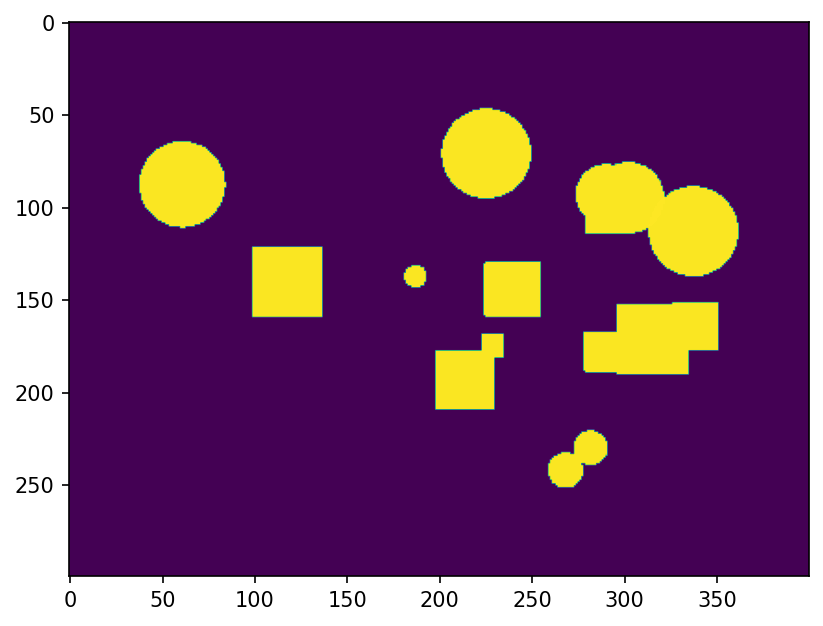

In [2]:
!gdown 1XZsPMwrLK9zbN9VHDm5vY6F7pCO-a2go
img = np.load("img.npy")

plt.figure(dpi=150)
plt.imshow(img);

In [3]:
img = torch.from_numpy(img)

At first, we'll experiment with `nn.functional.conv2d` - the function that performs 2d image convolution.

Note: this function is designed to work in the context of a neural network (i.e. where input and output come in batches and have multiple channels), so the functin expects 4D tensors rather than 2D. We'll write a short wrapper to work with 2D images.

In [4]:
def convolve(img, kernel):
    kernel = kernel[None, None, ...]

    result = nn.functional.conv2d(img[None, None, ...].float(), kernel)

    return result.squeeze()

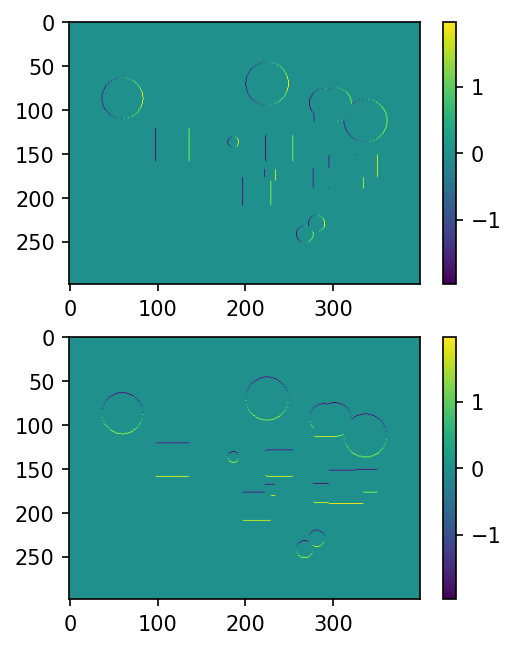

In [5]:
kernel_ver_edge = torch.tensor(
    [[ 1., -1.],
     [ 1., -1.]]
)
kernel_hor_edge = torch.tensor(
    [[ 1.,  1.],
     [-1., -1.]]
)

vertical_edges = convolve(img, kernel_ver_edge)
horizontal_edges = convolve(img, kernel_hor_edge)

plt.figure(figsize=(4, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.imshow(vertical_edges);
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(horizontal_edges);
plt.colorbar();

We can combine the result, e.g. like this:

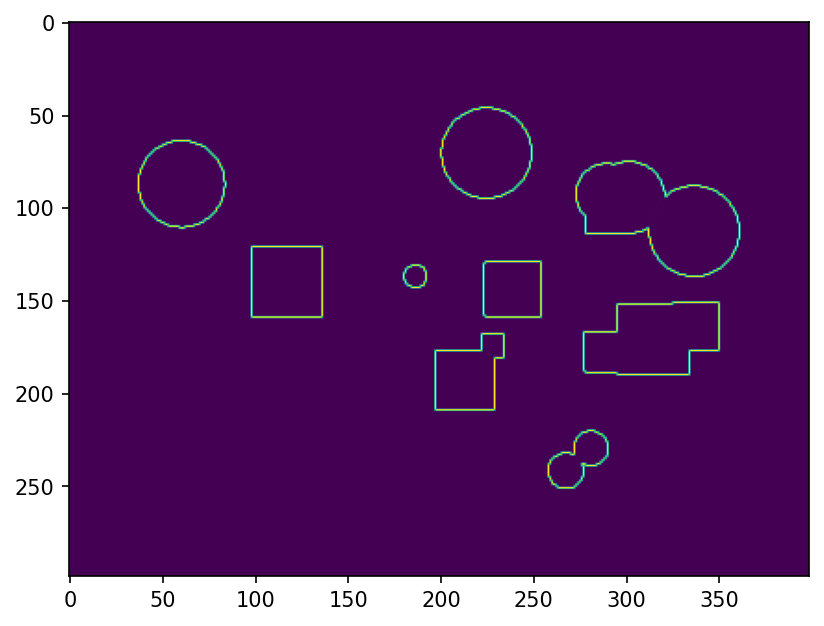

In [6]:
edges = (vertical_edges**2 + horizontal_edges**2)**0.5
plt.figure(dpi=150)
plt.imshow(edges);

Another example, blurring kernel:

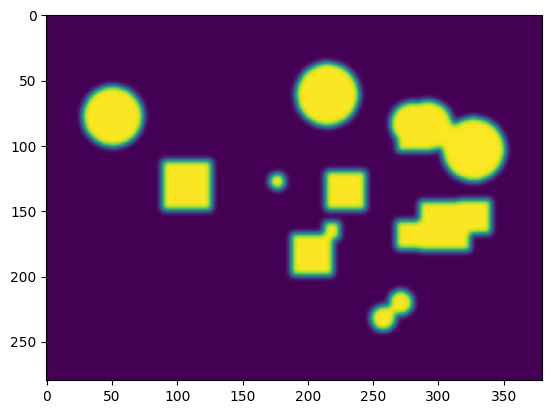

In [7]:
kernel_blur = torch.tensor([[1.,  4.,  7.,  4., 1.],
                                    [4., 16., 26., 16., 4.],
                                    [7., 26., 41., 26., 7.],
                                    [4., 16., 26., 16., 4.],
                                    [1.,  4.,  7.,  4., 1.]]) / 273

edges_blurred = convolve(img, kernel_blur)

## Uncomment these lines one by one to see the effect
## gradually increasing:
edges_blurred = convolve(edges_blurred, kernel_blur)
edges_blurred = convolve(edges_blurred, kernel_blur)
edges_blurred = convolve(edges_blurred, kernel_blur)
edges_blurred = convolve(edges_blurred, kernel_blur)
## Keep them **uncommented** for the further code to work

plt.imshow(edges_blurred.detach().numpy());

Let's pick up a small patch out of this image:

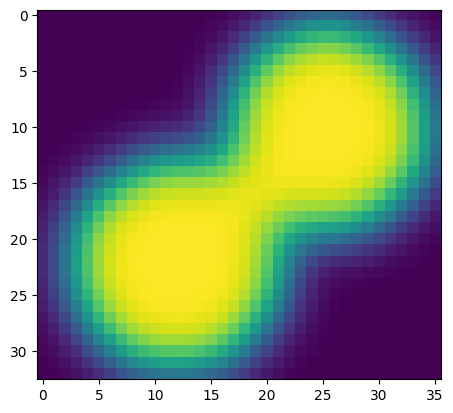

In [8]:
edges_subset = edges_blurred[210:243, 246:282]
plt.imshow(edges_subset);

What do you think will happen if we use this patch as a kernel when running convolution on the edges image?

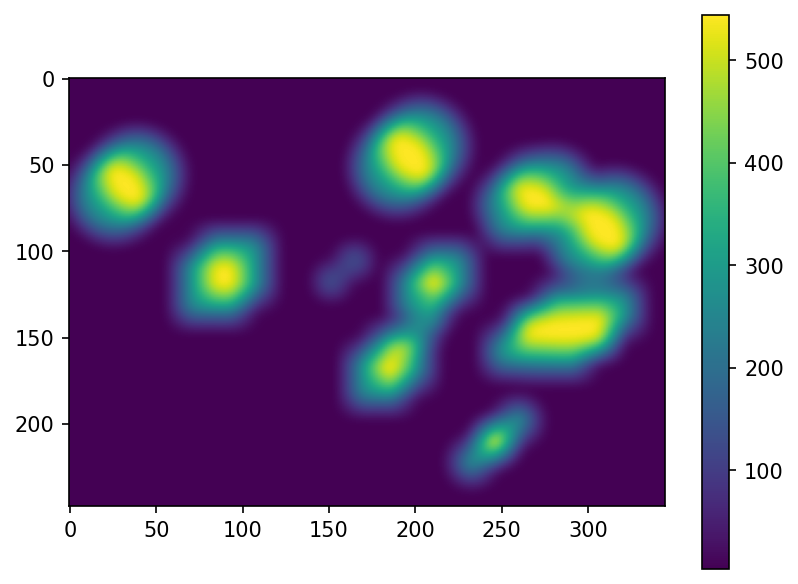

In [9]:
plt.figure(dpi=150)
plt.imshow(convolve(edges_blurred, edges_subset))
plt.colorbar();

Note how this kernel highlighted the location of that shape on the input!

We can either have a look at kernels of pretrained models.

In [10]:
def show_kernels(conv_layer, num_cols=8):
    kernels = conv_layer.weight.data
    num_rows = int(np.ceil(len(kernels) / num_cols))
    plt.figure(figsize=(12, 12 // num_cols * num_rows))

    for i, w in enumerate(kernels, 1):
        w = w.cpu().numpy().transpose(1, 2, 0)
        w -= w.min()
        w /= w.max()

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(w)
        plt.axis("off")

    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


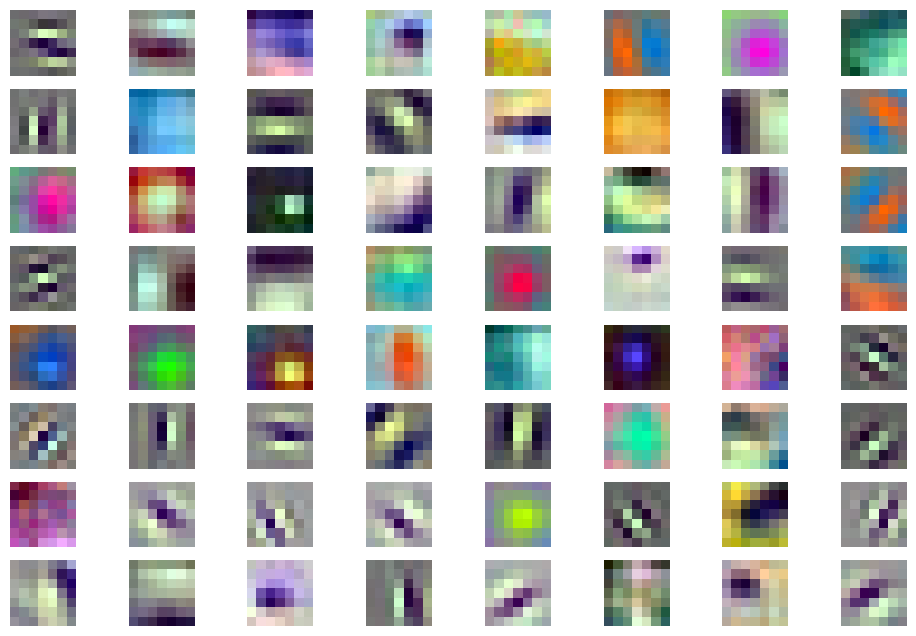

In [13]:
resnet18_pt = resnet18(pretrained=True)
show_kernels(resnet18_pt.conv1)

Now let's build up a ResNet model, using Conv layers, and compare it's performance depending on batch norm and residual blocks. Based on a great [VK CV course](https://github.com/lysukhin/vk-academy-dl-cv/tree/2022/computer_vision) notebook.

# CNNs

![kernel](https://miro.medium.com/max/640/1*1okwhewf5KCtIPaFib4XaA.gif)


* stride controls the stride for the cross-correlation, a single number or a tuple.

* padding controls the amount of padding applied to the input. It can be either a string {‘valid’, ‘same’} or a tuple of ints giving the amount of implicit padding applied on both sides.

* dilation controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.

You may check other visualizations [here](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d).

## Training routine

In [11]:
def plot(arr, label=""):
    plt.plot(arr, label=label)
    plt.xlabel("iterations")
    plt.ylabel("CE loss")
    plt.grid(True)
    plt.legend()

In [12]:
DATASET = "CIFAR10"
DEVICE = "cuda:0"
NUM_EPOCHS = 2
BATCH_SIZE = 256
LR = 3e-4

In [13]:
transforms = Compose([
    ToTensor(),
    Normalize(0.5, 0.25, inplace=True),
])

IMAGE_CHANNELS = 3
NUM_CLASSES = 10

dataset = CIFAR10("./dataset/cifar", download=True, transform=transforms)


100%|██████████| 170498071/170498071 [00:05<00:00, 30275495.68it/s]


Extracting ./dataset/cifar/cifar-10-python.tar.gz to ./dataset/cifar


Complete the code below, following function's docstring.

In [14]:
def train_model(model,
                dataset=dataset,
                num_epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                lr=LR,
                device=DEVICE):
    """Model training routine function.
    Uses Adam optimizer & cross-entropy loss.

    Args:
        model: torch.nn.Module
        dataset: torch.utils.data.Dataset
        num_epochs: int
        batch_size: int
        lr: float
        device: str

    Returns:
        losses: list of float values of length num_epochs * len(dataloader)
    """
    model.train()
    model = model.to(device)

    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    optimizer = Adam(model.parameters(), lr = lr)

    losses = []
    for epoch in range(num_epochs):
        for batch in tqdm.tqdm(dataloader):
            xs, ys_true = batch

            logits_pred = model(xs.to(device))

            loss = cross_entropy(logits_pred.to(device), ys_true.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    return losses

100%|██████████| 196/196 [00:13<00:00, 14.43it/s]


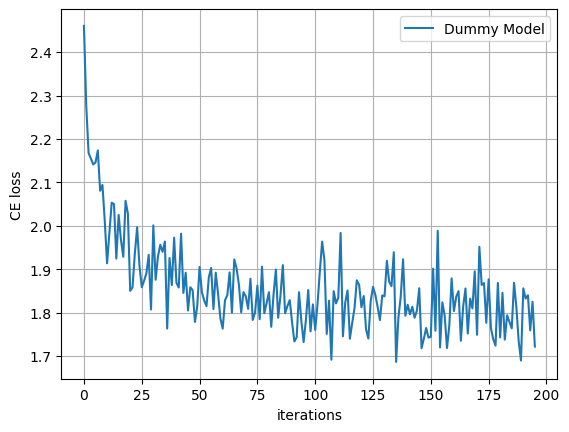

In [15]:
# TESTS for train()

input_size = dataset[0][0].size()
dummy_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(np.prod(input_size), NUM_CLASSES)
)
losses_dummy = train_model(dummy_model, dataset, num_epochs=1)

#assert len(losses_dummy) == len(dataset) // BATCH_SIZE
#assert np.mean(losses_dummy[:10]) > np.mean(losses_dummy[-10:])

plot(losses_dummy, "Dummy Model")

## ResNet

[ResNet](https://arxiv.org/abs/1512.03385) architecture:

![resnet34](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/resnet_architecture.png)

You can find exact impementation inside [torchvision code](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py), it may be helpful for you during other experiments as you can check how some particular model is implemented. However, let's try to create our own ResNet with 10 layers.

As we are going to use `Conv2` -> `ReLU` -> `BatchNorm2d` sequence way too often, let's implement a function to create such a sequence. Note, that convolutional layer musts preserve spatial tensor dims (i.e. apply zero padding).

In [54]:
def get_conv(kernel_size,
             in_features,
             out_features,
             with_bn=True,
             with_relu=True):
    """Create conv -> [relu] -> [bn] layers, embedded in torch.nn.Sequential module.

    ! Conv layer must preserve spatial tensor dims (i.e. apply zero padding).

    Args:
        kernel_size: int
        in_features: int
        out_features: int
        with_bn: bool
        with_relu: bool

    Returns:
        torch.nn.Sequential
    """
    layers = [
        nn.Conv2d(in_features, out_features, kernel_size, 1, kernel_size // 2)
    ]

    # replace with ReLU6 from nn.functional.relu6
    # if you face problem on colab
    if with_relu:
        layers.append(nn.ReLU6(inplace=(with_bn is True)))

    if with_bn:
        layers.append(nn.BatchNorm2d(out_features))

    return nn.Sequential(*layers)

In [56]:
# TESTS for get_conv()
conv = get_conv(3, 8, 16)

assert len(conv) == 3
assert isinstance(conv[0], torch.nn.Conv2d)
assert conv[0].in_channels == 8
assert conv[0].out_channels == 16

assert isinstance(conv[1], torch.nn.ReLU6)

assert isinstance(conv[2], torch.nn.BatchNorm2d)
assert conv[2].num_features == 16


conv = get_conv(3, 8, 16, with_bn=False, with_relu=False)

assert len(conv) == 1
assert isinstance(conv[0], torch.nn.Conv2d)
assert conv[0].in_channels == 8
assert conv[0].out_channels == 16

Global Average Pooling is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the **average of each feature map**.

One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps.
Another advantage is that there is **no parameter to optimize in the global average pooling** thus overfitting is avoided at this layer. Furthermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.

Implement `GlobalAveragePooling2d` class to use it in ResNet model.

In [57]:
class GlobalAveragePooling2d(nn.Module):
    def forward(self, x):
        """GAP forward pass.

        Args:
            x: torch.Tensor, size B x C x H x W.

        Returns:
            torch.Tensor, size B x C.
        """
        y = x.mean((-1, -2))
        return y

In [58]:
# TESTS for GAP

gap = GlobalAveragePooling2d()
x = torch.randn(4, 3, 16, 16)
y = gap(x)

assert y.size() == (4, 3)

## Residual Block

In traditional neural networks, each layer feeds into the next layer. In a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away.


![residual_block](https://miro.medium.com/max/720/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


Note, that  `x` and `F(x)` may have different shapes.
We can also redefine `__repr__` to may the `print` output fancier.


In [59]:
class ResidualBlock(nn.Module):
    def __init__(self, num_input_features, num_features, num_layers, with_bn=True, residual=True):
        super().__init__()

        if residual:
            if num_input_features != num_features:
                self.projection = nn.Conv2d(num_input_features, num_features, 1, 1, 0)
            else:
                self.projection = None

        layers = []
        for i in range(num_layers):
            conv = get_conv(3, num_input_features, num_features, with_bn=with_bn)
            layers.append(conv)
            num_input_features = num_features
        self.layers = nn.Sequential(*layers)

        self.num_input_features = num_input_features
        self.num_features = num_features
        self.num_layers = num_layers
        self.with_bn = with_bn

    def forward(self, x):
        """Forward pass.
        Applies convolution layers and skip-connection; self.projection, if necessary.

        Args:
            x: torch.Tensor, size B x C x H x W.

        Returns:
            torch.Tensor, size B x C x H x W.
        """
        x_input = x

        for layer in self.layers:
            x = layer(x)

        if self.projection is not None:
            x += self.projection(x_input)
        else:
            x += x_input

        return relu(x)

    def __repr__(self):
        out = f"ResidualBlock(num_input_features={self.num_input_features}, num_features={self.num_features}, num_layers={self.num_layers}, with_bn={self.with_bn})"
        for l in self.layers:
            out += "\n" + "\t" + repr(l)
        return out

In [60]:
# TESTS for ResidualBlock
block = ResidualBlock(4, 4, 2)

assert len(block.layers) == 2
assert len(block.layers[0]) == 3
assert len(block.layers[1]) == 3
assert isinstance(block.layers[1][2], nn.BatchNorm2d)

print(block)

ResidualBlock(num_input_features=4, num_features=4, num_layers=2, with_bn=True)
	Sequential(
  (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU6(inplace=True)
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
	Sequential(
  (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU6(inplace=True)
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Finally, let's combine it and implement the `build_resnet` function, as it would be easier to call it instead of copypasting through our experiments.

In [61]:
def build_resnet(num_input_features=IMAGE_CHANNELS,
                 num_classes=NUM_CLASSES,
                 with_bn=True,
                 block = ResidualBlock):

    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)

    resnet = nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        block(64, 64, 2, with_bn=with_bn),
        pool,
        block(64, 128, 2, with_bn=with_bn),
        pool,
        block(128, 256, 2, with_bn=with_bn),
        pool,
        block(256, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

    return resnet

In [62]:
resnet = build_resnet()

In [63]:
losses_resnet= train_model(resnet, device="cuda:0")

100%|██████████| 196/196 [00:26<00:00,  7.48it/s]


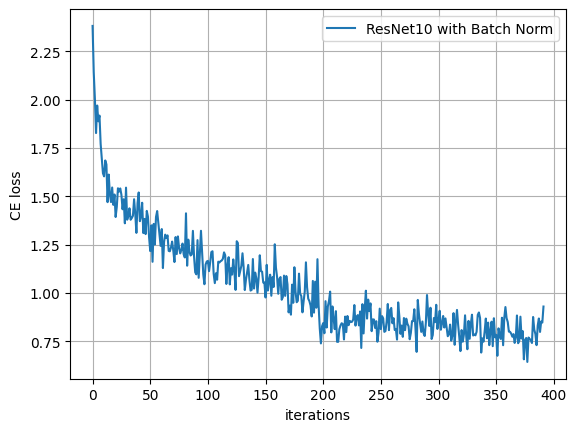

In [64]:
plot(losses_resnet, label="ResNet10 with Batch Norm")

## Batch Normalization Effect


Now, we create another instance of ResNet but do not use batch normalization. So, let's check how it affects the results.

In [65]:
resnet_wo_bn = build_resnet(with_bn=False)

In [66]:
losses_resnet_wo_bn = train_model(resnet_wo_bn)

100%|██████████| 196/196 [00:23<00:00,  8.25it/s]


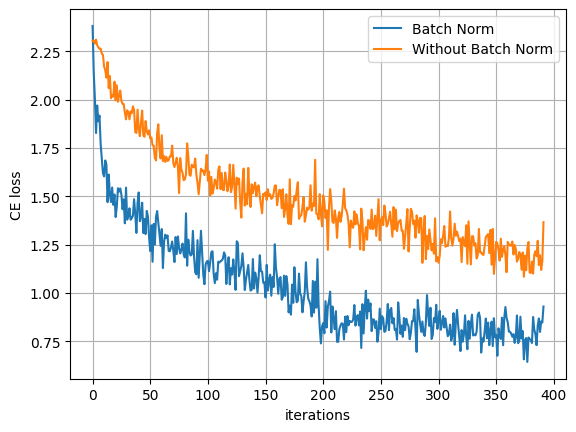

In [67]:
plot(losses_resnet, label="Batch Norm")
plot(losses_resnet_wo_bn, label="Without Batch Norm")

## Residual-connections Effect


Now we get rid of residual connections and compare the results. We may reuse the previous class, deleting everything redundant.🤡

In [68]:
class Block(ResidualBlock):
    def __init__(self, num_input_features, num_features, num_layers, with_bn=True):
        super().__init__(num_input_features, num_features, num_layers, with_bn, False)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        out = f"Block(num_input_features={self.num_input_features}, num_features={self.num_features}, num_layers={self.num_layers}, with_bn={self.with_bn})"
        for l in self.layers:
            out += "\n" + "\t" + repr(l)
        return out

In [69]:
net10 = build_resnet(block=Block)
net10;

In [70]:
losses_net = train_model(net10)

100%|██████████| 196/196 [00:24<00:00,  8.02it/s]


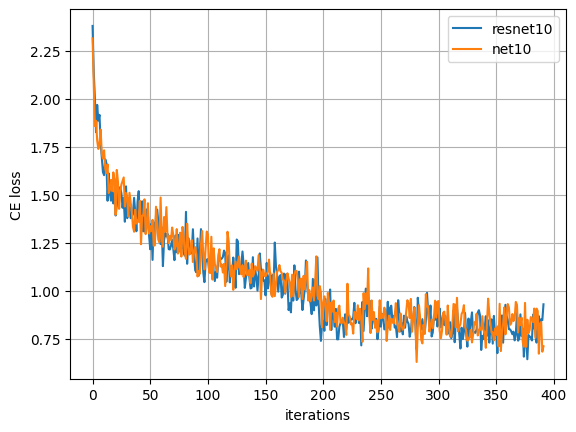

In [71]:
plot(losses_resnet, label="resnet10")
plot(losses_net, label="net10")

Why do we see no difference here?

Looks like we need to go deeper. Let's increase the number of blocks.

In [72]:
def build_resnet(num_input_features=IMAGE_CHANNELS,
                 num_classes=NUM_CLASSES,
                 with_bn=True,
                 block = ResidualBlock):

    pool = nn.MaxPool2d((2, 2))
    gap = GlobalAveragePooling2d()
    fc = nn.Linear(512, num_classes)

    resnet = nn.Sequential(
        get_conv(7, num_input_features, 64, with_bn=with_bn),
        pool,
        block(64, 64, 2, with_bn=with_bn),
        block(64, 64, 2, with_bn=with_bn),
        block(64, 64, 2, with_bn=with_bn),
        pool,
        block(64, 128, 2, with_bn=with_bn),
        block(128, 128, 2, with_bn=with_bn),
        block(128, 128, 2, with_bn=with_bn),
        pool,
        block(128, 256, 2, with_bn=with_bn),
        block(256, 256, 2, with_bn=with_bn),
        block(256, 256, 2, with_bn=with_bn),
        block(256, 256, 2, with_bn=with_bn),
        block(256, 256, 2, with_bn=with_bn),
        pool,
        block(256, 512, 2, with_bn=with_bn),
        block(512, 512, 2, with_bn=with_bn),
        block(512, 512, 2, with_bn=with_bn),
        gap,
        fc
    )

    return resnet

In [73]:
resnet_34 = build_resnet(block=ResidualBlock)

In [74]:
losses_resnet_34 = train_model(resnet_34)

100%|██████████| 196/196 [00:46<00:00,  4.18it/s]


In [75]:
model_34 = build_resnet(block=Block)

In [76]:
losses_model_34 = train_model(model_34)

100%|██████████| 196/196 [00:43<00:00,  4.55it/s]


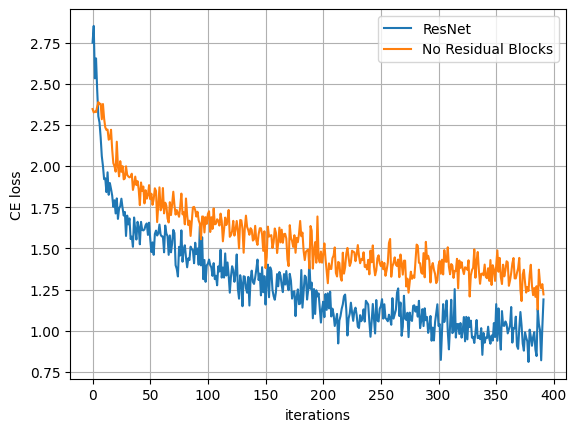

In [77]:
plot(losses_resnet_34 , "ResNet")
plot(losses_model_34, "No Residual Blocks")